## Move accuracy (sparq)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, split, posexplode, regexp_extract,
    when, lag, exp, lit, sha2, concat_ws, 
    floor, avg, count
)
from pyspark.sql.window import Window


# ----------------------------
# Spark session
# ----------------------------
spark = (
    SparkSession.builder
    .appName("Lichess Move Accuracy")
    .getOrCreate()
)

# ----------------------------
# Read data
# ----------------------------
chess = spark.read.parquet(
    "/data/doina/Lichess/lichess_db_standard_rated_2017*.parquet"
)


# Only games with evals
chess = chess.filter(col("Moves").contains("%eval"))

# ----------------------------
# Create game_id
# ----------------------------
chess = chess.withColumn(
    "game_id",
    sha2(
        concat_ws("||", "Site", "UTCDate", "UTCTime"),
        256
    )
)

# ----------------------------
# Explode moves
# ----------------------------
moves = chess.select(
    "game_id",
    "Moves",
    "WhiteElo",
    "BlackElo",
    "TimeControl"
)

moves = moves.withColumn(
    "move_array",
    split(col("Moves"), r"\}\s*")
)

moves = moves.select(
    "*",
    posexplode("move_array").alias("move_index", "move_text")
)

# ----------------------------
# Extract eval and clock
# ----------------------------
moves = moves.withColumn(
    "eval_pawns",
    regexp_extract(
        "move_text", r"%eval\s+(-?\d+\.?\d*)", 1
    ).cast("double")
).withColumn(
    "centipawns",
    col("eval_pawns") * 100
).withColumn(
    "clock",
    regexp_extract(
        "move_text", r"%clk\s+(\d+:\d+:\d+)", 1
    )
)

# ----------------------------
# Player & Elo
# ----------------------------
moves = moves.withColumn(
    "player",
    when(col("move_index") % 2 == 0, lit("White"))
    .otherwise(lit("Black"))
)

moves = moves.withColumn(
    "player_elo",
    when(col("player") == "White", col("WhiteElo"))
    .otherwise(col("BlackElo"))
)

# ----------------------------
# Clock to seconds
# ----------------------------
moves = moves.withColumn(
    "clock_seconds",
    split(col("clock"), ":")[0].cast("int") * 3600 +
    split(col("clock"), ":")[1].cast("int") * 60 +
    split(col("clock"), ":")[2].cast("int")
)

# ----------------------------
# Time spent per move (per game & player)
# ----------------------------
w_player = (
    Window
    .partitionBy("game_id", "player")
    .orderBy("move_index")
)

moves = moves.withColumn(
    "time_spent",
    lag("clock_seconds").over(w_player) - col("clock_seconds")
)

# ----------------------------
# Win probability
# ----------------------------
moves = moves.withColumn(
    "win_percent",
    50 + 50 * (
        2 / (1 + exp(-0.00368208 * col("centipawns"))) - 1
    )
)

# ----------------------------
# Accuracy (per game)
# ----------------------------
w_game = (
    Window
    .partitionBy("game_id")
    .orderBy("move_index")
)

moves = moves.withColumn(
    "win_percent_before",
    lag("win_percent").over(w_game)
)

moves = moves.withColumn(
    "accuracy",
    103.1668 * exp(
        -0.04354 * (
            col("win_percent_before") - col("win_percent")
        )
    ) - 3.1669
)

# Clamp accuracy to [0, 100]
moves = moves.withColumn(
    "accuracy",
    when(col("accuracy") > 100, 100)
    .when(col("accuracy") < 0, 0)
    .otherwise(col("accuracy"))
)

# ----------------------------
# Final dataset
# ----------------------------
final_moves = moves.select(
    "game_id",
    "move_index",
    "player",
    "player_elo",
    "centipawns",
    "win_percent_before",
    "win_percent",
    "accuracy",
    "time_spent",
    "TimeControl"
)

# ----------------------------
# Write outputs
# ----------------------------
# final_moves.repartition(200).write \
#     .mode("overwrite") \
#     .parquet("chess_moves_accuracy_2301.parquet")

# final_moves.repartition(200).write \
#     .mode("overwrite") \
#     .option("header", "true") \
#     .csv("chess_moves_accuracy_2301.csv")

# binned_elo = (
#     final_moves
#     .filter(col("time_spent").isNotNull())
#     .filter(col("time_spent").between(0, 60))
#     .filter(col("player_elo").isNotNull())
#     .withColumn("time_bin", floor(col("time_spent")))
#     .withColumn(
#         "elo_band",
#         (col("player_elo") / 200).cast("int") * 200
#     )
#     .groupBy("elo_band", "time_bin")
#     .agg(
#         avg("accuracy").alias("avg_accuracy"),
#         count("*").alias("n_moves")
#     )
#     .orderBy("elo_band", "time_bin")
# )

binned_elo = (
    final_moves
    .filter(col("time_spent").isNotNull())
    .filter(col("time_spent").between(0, 60))
    .filter(col("player_elo").isNotNull())
    .withColumn("time_bin", floor(col("time_spent")))
    .withColumn(
        "elo_band",
        when(col("player_elo") < 1400, "<1400")
        .when(col("player_elo").between(1400, 1999), "1400–1999")
        .otherwise("2000+")
    )
    .groupBy("elo_band", "time_bin")
    .agg(
        avg("accuracy").alias("avg_accuracy"),
        count("*").alias("n_moves")
    )
    .orderBy("elo_band", "time_bin")
)

binned_elo.coalesce(1).write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv("binned_accuracy_vs_time_elo")

## Load and plot data (locally)

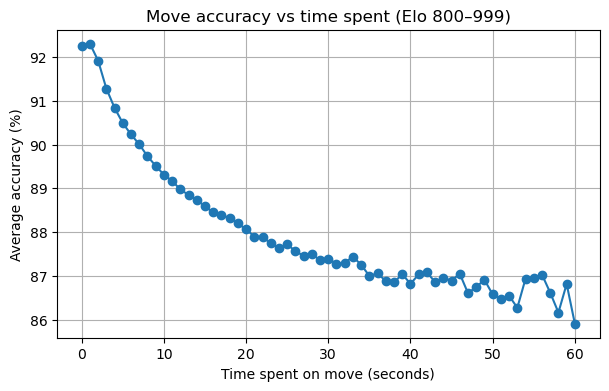

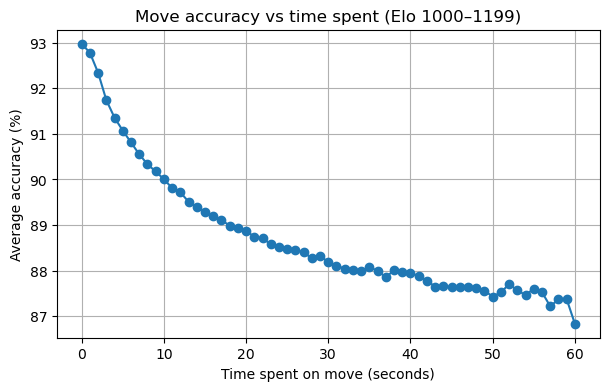

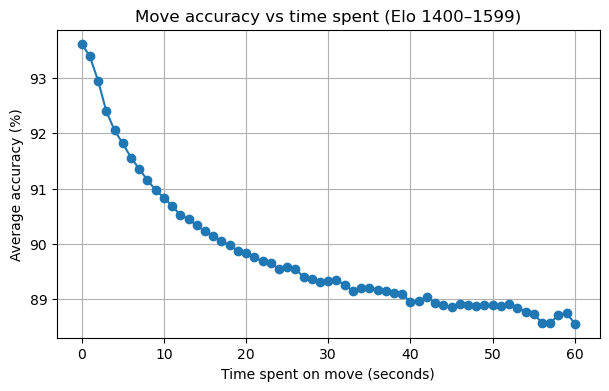

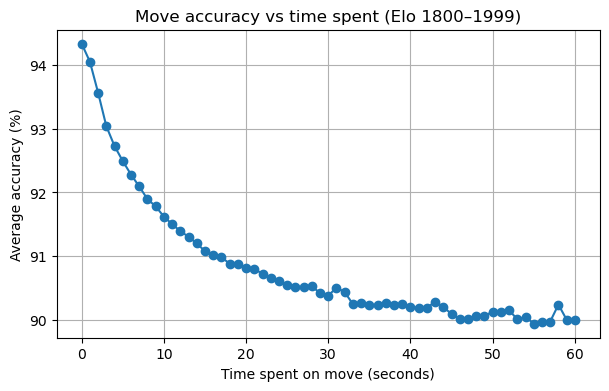

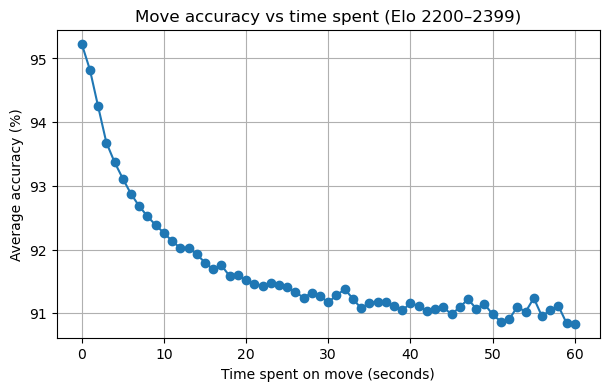

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = pd.read_csv("accuracy-per-move-2301.csv")

elo_ranges = [800, 1000, 1400, 1800, 2200]

for elo in elo_ranges:
    subset = pdf[pdf["elo_band"] == elo]

    plt.figure(figsize=(7, 4))
    plt.plot(
        subset["time_bin"],
        subset["avg_accuracy"],
        marker="o"
    )

    plt.title(f"Move accuracy vs time spent (Elo {elo}–{elo+199})")
    plt.xlabel("Time spent on move (seconds)")
    plt.ylabel("Average accuracy (%)")
    plt.grid(True)
    plt.show()


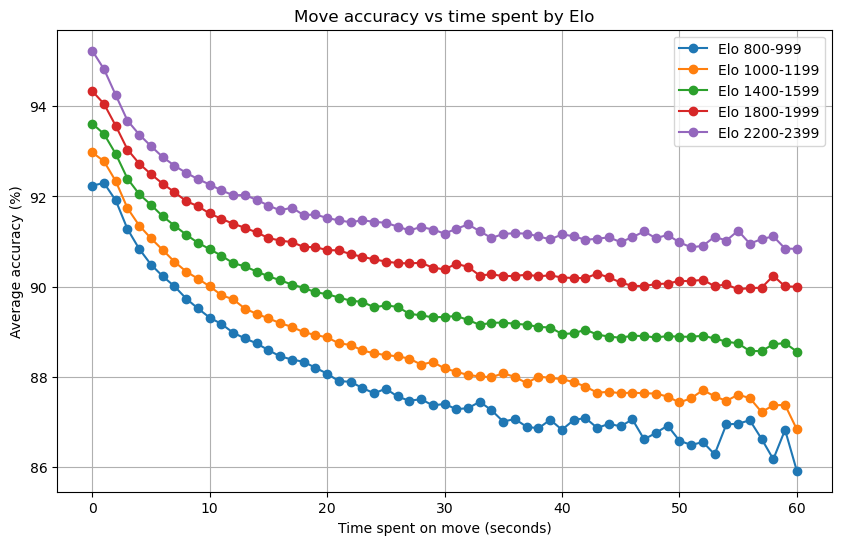

In [9]:
import matplotlib.pyplot as plt

# Define Elo bands to plot
elo_ranges = [800, 1000, 1400, 1800, 2200]

plt.figure(figsize=(10, 6))

# Loop through each Elo band and plot a line
for elo in elo_ranges:
    subset = pdf[pdf["elo_band"] == elo]
    plt.plot(
        subset["time_bin"],
        subset["avg_accuracy"],
        marker="o",
        label=f"Elo {elo}-{elo+199}"
    )

plt.xlabel("Time spent on move (seconds)")
plt.ylabel("Average accuracy (%)")
plt.title("Move accuracy vs time spent by Elo")
plt.legend()
plt.grid(True)
plt.show()


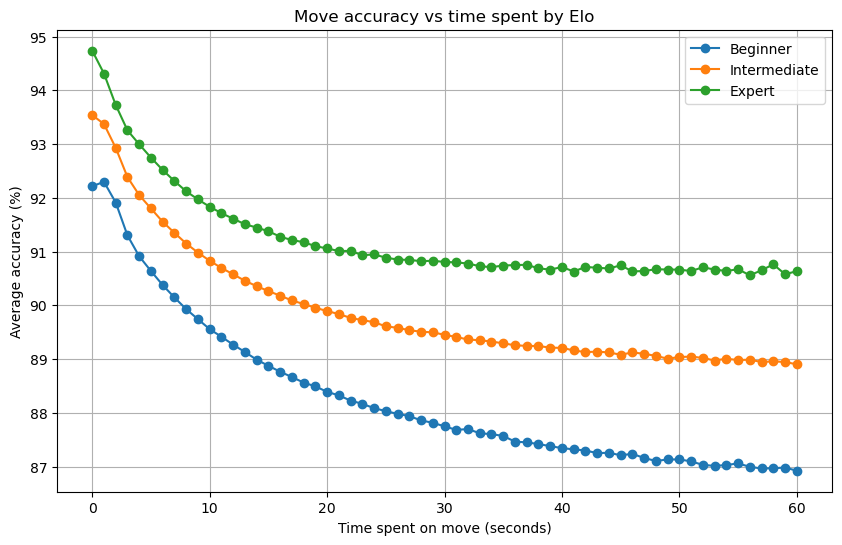

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# pdf = pd.read_csv("3bin-accuracy-2301.csv")
pdf = pd.read_csv("accuracy_results/accuracy2020.csv")
# Define Elo bands to plot
elo_ranges = ['<1400', '1400–1999', '2000+']

plt.figure(figsize=(10, 6))

# Loop through each Elo band and plot a line
for elo in elo_ranges:
    subset = pdf[pdf["elo_band"] == elo]
    level = "Beginner" if elo == '<1400' else "Intermediate" if elo == '1400–1999' else "Expert"
    plt.plot(
        subset["time_bin"],
        subset["avg_accuracy"],
        marker="o",
        label=f"{level}"
    )

plt.xlabel("Time spent on move (seconds)")
plt.ylabel("Average accuracy (%)")
plt.title("Move accuracy vs time spent by Elo")
plt.legend()
plt.grid(True)
plt.show()
